# 12. 해밀턴 몬테카를로 (HMC)
- 타겟 함수의 기울기 정보를 활용하면 MCMC 수렴 속도를 향상시킬 수 있음
- 이러한 정보를 사용하는 방법은, 단순한 랜덤 워크가 다양한 방향으로 퍼져나가기 쉬운 고차원 공간에서 특히 유용

<br>

## 12-01.  Metropolis-adjusted Langevin
- 기울기 정보를 도입하는 가장 단순한 방법은 Metropolis-adjusted Langevin 알고리즘(MALA)로, 
    
    이는 타겟 분포 $\phi(\theta)$를 정상 분포로 갖는 가역적인 랑주뱅 확산을 시뮬레이션
    
$$\mathrm{d}\mathbf{\theta}_t = \sigma \mathrm{d}B_t + \frac{\sigma^2}{2} \nabla \log \pi(\mathbf{\theta}_t) \mathrm{d}t.$$

- 위 식은 확률 미분방정식으로, $B_t$는 표준 $d$차원 브라운 운동 (독립적으로 정규분포를 따르는 증분을 갖는 확률과정)을 나타냄

<br>

- 랑주뱅 확산 과정을 이해하는 가장 간단한 방법은 시간 이산화

$$\mathbf{\theta}'_{t+1} = \mathbf{\theta}_t + \sigma_n \mathbf{z}_{t+1} + \frac{\sigma_n^2}{2} \nabla \log \pi(\mathbf{\theta}_t),$$

where $\mathbf{z}_{t+1} \sim \mathcal{N}(0, \mathbf{I}_d).$

- $\sigma_n$이 작아질수록 이산화된 과정은 원래의 확산 과정을 더 정확히 근사하지만, 
    
    유한한 $\sigma_n$의 경우 정상 분포로의 수렴을 보장하기 위해 MH (Metropolis-Hastings) 수용/거부 단계가 추가
    
    이때 제안된 값은 보통 다음의 확률로 수용
    
$$\alpha(\mathbf{\theta}_t, \mathbf{\theta}'_{t+1}) = \frac{\pi(\mathbf{\theta}'_{t+1})}{\pi(\mathbf{\theta}_t)} \frac{q(\mathbf{\theta}_t; \mathbf{\theta}'_{t+1})}{q(\mathbf{\theta}'_{t+1}; \mathbf{\theta}_t)},$$

where

$$q(\mathbf{\theta}'_{t+1}; \mathbf{\theta}_t) = \mathcal{N}\left(\mathbf{\theta}'_{t+1};\; \mathbf{\theta}_t + \frac{\sigma_n^2}{2} \nabla \log \pi(\mathbf{\theta}_t), \sigma_n^2 \mathbf{I}_d \right).$$

- MALA는 좋은 이동 방향을 찾는 데 도움을 주어 고차원 공간에서 특히 중요하지만, 
    
    높은 수용률을 유지하기 위해서는 비교적 짧은 스텝을 사용해야 함

- 실제로 MALA 알고리즘 자체는 널리 사용되지는 않지만, 최근 머신러닝 분야에서는 매우 큰 데이터 집합에 대해 MCMC를 수행할 때 확률적 경사 기반 MCMC 방법의 기초로 채택

<br>

## 12-02. 해밀턴 몬테카를로 (HMC)
- 현재 가장 효율적인 범용 샘플러는 해밀토니안 몬테카를로 (Hamiltonian Monte Carlo, HMC)에 기반
- 이는 시스템의 위치 에너지로 작용하는 $−\log \pi(\theta)$를 이용해 동적 시스템을 정의하고, 
    
    해밀토니안 역학을 통해 이를 시뮬레이션하는 방식으로 개발
    
<br>

- 해밀토니안 역학은 시스템의 에너지와 부피를 보존하며, 적절한 수치 해법을 사용하면,  수치적 해에서도 동일한 보존 특성을 유지

    $\rightarrow$ 매우 긴 궤적을 높은 수용 확률로 시뮬레이션

<br>

- **HMC에서는 각 일반적인 위치(position) 변수 $\theta_i$에 대해, 대응하는 '운동량'(momentum) 변수 $r_i \sim N(0,1)$ (많은 물리학 문헌에서는 $p_i$로 표기됨)을 추가**
    
    - **타겟 분포에 의해 정의된 위치 에너지를 $U(\theta) = -\log \pi(\theta)$로 나타내면**
        
        **운동량 변수는 $K(r) = \sum^d_{i=1} \frac{1}{2} r^2_i$의 운동 에너지를 가짐**
        
        **따라서 전체 에너지는** **$H(\mathbf{\theta}, \mathbf{r}) = U(\mathbf{\theta}) + K(\mathbf{r})$**


- 시스템의 해밀토니안 역학은

$$\begin{align*}
  \frac{\mathrm{d} \theta_i}{\mathrm{d}t} &= \frac{\partial H(\mathbf{\theta}, \mathbf{r})}{\partial r_i} \\
  \frac{\mathrm{d} r_i}{\mathrm{d}t} &= - \frac{\partial H(\mathbf{\theta}, \mathbf{r})}{\partial \theta_i}.
\end{align*}$$

전체 에너지를 $H(\theta, r) = -\log \pi(\theta) + \sum^d_{i=1} \frac{1}{2} r^2_i$로 정의함에 따라

$$\begin{align*}
  \frac{\mathrm{d} \theta_i}{\mathrm{d}t} &= r_i \\
  \frac{\mathrm{d} r_i}{\mathrm{d}t} &= - \frac{\partial U(\mathbf{\theta})}{\partial \theta_i} = \frac{\partial \log \pi(\mathbf{\theta})}{\partial \theta_i}.
\end{align*}$$

<br>

## 12-03. 해밀턴 역학의 수치적 해법
- **이러한 방정식을 수치적으로 시뮬레이션하는 가장 일반적인 방법은 leapfrog 적분법을 사용**


$$\begin{align*}
  \mathbf{r}(t + \epsilon/2) &= \mathbf{r}(t) - (\epsilon/2) \nabla_{\mathbf{\theta}} U(\mathbf{\theta}(t)) \\
  \mathbf{\theta}(t + \epsilon) &= \mathbf{\theta}(t) + \epsilon \mathbf{r}(t + \epsilon/2) \\
  \mathbf{r}(t + \epsilon) &= \mathbf{r}(t + \epsilon/2) - (\epsilon/2) \nabla_{\mathbf{\theta}} U(\mathbf{\theta}(t + \epsilon)).
\end{align*}$$

<br>

## 12-04. HMC 알고리즘
- 이 코드는 `target(theta)`가 타겟 로그밀도분포를 정의하고 `gradF(theta)`가 타겟의 기울기를 제공한다고 가정

<br>

1. 알고리즘의 각 단계는 정규분포를 따르는 랜덤 운동량 $r$의 시뮬레이션으로 시작
    
    이는 별도의 MH 제안 단계이지만, $r$이 정확한 조건부 분포로부터 추출되므로 항상 수용됩니다.
    
2. 이 운동량을 바탕으로 $L$번의 leapfrog 스텝을 시뮬레이션하여, 새로운 제안 쌍 $(\theta', r')$을 얻음
    
    제안된 쌍은 이후 ($\theta, r)$의 확장된 공간에서 MH수용 규칙에 따라 수용/거부
    
3. 수용 확률의 로그 $\log a$는 제안된 trace의 시작과 끝에서의 총 에너지 차이에 따라 결정

$$\log a = H(\mathbf{\theta}, \mathbf{r}) - H(\mathbf{\theta}', \mathbf{r}'),$$
- $(\theta, r)$은 현재 상태, $(\theta', r')$은 여러 스텝 동안 해밀토니안 시뮬레이션을 하여 얻은 제안 상태를 의미
- 정확한 시뮬레이션은 에너지를 보존하기 때문에, 만약 시뮬레이션이 완벽하게 이루어진다면,
    
    HMC의 모든 제안은 시뮬레이션 길이에 상관없이 수용확률 $a=1$을 가지게 됨
    
    하지만 실제로는 $\epsilon$으로 인한 부정확한 시뮬레이션으로 인해, 수용 검사가 필요

```python
g = gradF(theta)       """매개변수 theta 초기값에 대한 기울기 계산"""
logP = target(theta)   """매개변수 theta 초기값에 대한 로그 확률밀도값 계산"""

for m in range(M): """M번의 시행동안"""
    r ~ Normal(0, I)       """초기 운동량 r을 정규분포 N(0, 1)에서 샘플링"""
    H = r.T @ r / 2 - logP   """현재 상태 (theta, r)에 대한 총 에너지 H(theta, r)계산"""
    
    """현재 상태에 대하여"""
    thetanew = theta
    gnew = g
    
    for l in range(L):       """L번의 leapfrog 수행"""
        r = r + epsilon * gnew / 2   """1. 현재 상태의 r에 대해 half-step 갱신"""
        thetanew = thetanew + epsilon * r    """2. 현재 상태의 theta에 대해 full-step 갱신""" 
        gnew = gradF(thetanew)           """3. 갱신된 theta에 대한 기울기 계산"""
        r = r + epsilon * gnew / 2   """4. 현재 상태의 r에 대해 나머지 hafl-step 갱신""" 
        
    logPnew = target(thetanew)           """갱신된 theta에 대한 로그 확률밀도값 계산"""
    
    Hnew = r.T @ r / 2 - logPnew """갱신된 상태 (thetanew, r)에 대한 총 에너지 계산"""
    dH = Hnew - H    """에너지 총량의 차이 계산"""
    
    """MH에 따른 수용/기각"""
    if np.log(npr.rand()) < -dH:
        """갱신된 상태를 수용할 경우, 상태를 업데이트"""
        g = gnew
        theta = thetanew
        logP = logPnew
```

<br>

## 12-05. HMC 튜닝
- HMC에는 두 가지 튜닝 가능한 파라미터가 존재: 

<br>

#### **$\epsilon$** : 
- **수치적 적분의 정확도에 영향을 주어, 수용률에도 큰 영향을 미치므로 보통 더 쉽게 튜닝할 수 있음**
- 랜덤워크 MCMC 제안에서 수용률이 점진적으로 변하는 것과 달리,  $\epsilon$의 증가효과는 극단적일 수 있음

    - 처음에는 수용률이 거의 1에 가깝다가, 어느 시점 이후 급격히  0으로 하락

- **제안값 계산에 더 많은 계산이 필요한 만큼, HMC의 수용률은, 랜덤워크 MCMC보다 더 높아야 함**
    - 일반적으로 약 0.8의 수용률이 좋은 목표치로 여겨지며, $\epsilon$의 값은 0.1 정도가 적절한 것으로 알려짐

<br>

#### $L$
- HMC의 leapfrog trace는 부메랑이 날아가다 다시 돌아오는 경로와 유사
- **$L=1$이면, HMC는 단순한 랜덤워크 MCMC와 동일**

    $\rightarrow$ **HMC의 이점을 누리기 위해서는 더 큰 $L$값이 필요**
    
    $\rightarrow$ **$L$이 너무 크면, trace가 출발점으로 다시 돌아와, 샘플링 효율이 감소**
    
- **일반적으로 최적의 $L$은 trace마다 다르게 나타나며, 위의 문제는 No-U-Turn Sampler (NUTS)와 같은 동적 HMC알고리즘으로 해결 가능**

<br>

## 12-06. HMC이론
- 궁극적으로, 위에서 소개한 HMC 샘플러는 매우 복잡한 제안을 사용하는 MH로써,

    이로 인해 MH 수용 검사가 상세 균형(detailed balance)을 보장하고 원하는 분포로의 수렴을 보장
    
- HMC 제안값은 통합 경로가 주기적이지 않은 한 에르고딕 체인을 생성합니다. 
    
    - 예) 타겟 분포가 정규분포인 경우와 같이 주기적일 수 있으며, 이때 경로 길이가 주기와 일치하면 문제가 발생
    
    $\rightarrow$ 이러한 문제는 반복마다 경로나 스텝 길이를 무작위화하여 회피가능
    
    - 예) $\epsilon=v;\epsilon_0$으로 설정하고, $v\sim Uniform(0.8, 1.2)$와 같이 설정

<br>

- **HMC는 단봉 분포(unimodal distribution)에 대해 매우 효율적인 샘플링을 제공하지만,**
    
    **다봉 분포(multimodal distribution)의 문제를 해결하지는 못함**
    
    - 이론상 HMC는 봉우리 사이를 뛰어넘을 수 있지만, 
        
        봉우리들이 잘 분리되어 있는 경우, 정확히 올바른 방향으로, 충분히 큰 운동량 $r$을, 샘플링해야 하므로 그 가능성은 매우 낮음
    
        $\rightarrow$ HMC와 병행하여 병행 템퍼링과 같은 다른 기법들이 여전히 필요할 수 있음

<br>

## 12-07. HMC 예제

$$\log \pi(\mathbf{\theta}) = -20 (\|\mathbf{\theta}\|_2 - 10)^2,$$에 대해 HMC 샘플링

- 랜덤워크 MCMC는 원 주위에서 천천히 이동하기 때문에, 이 타겟분포에 대해 효율적인 탐색이 어렵지만,
    
    충분히 큰 $L$을 사용하는 HMC는 한 번의 이동으로 원을 건너뛸 수 있으며,
    
    매우 높은 수용률을 가짐

In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd
import matplotlib.pyplot as plt

- 로그 타겟밀도함수 : $\log \pi(\mathbf{\theta}) = -20 (\|\mathbf{\theta}\|_2 - 10)^2,$

In [ ]:
def sphere(theta):
    return -20*(np.sqrt(np.sum(theta**2))-10)**2

In [2]:
def hmc(theta0, M, target, epsilon, L):
    
    thetas = np.zeros([M, len(theta0)])
    gradF = autograd.grad(target)
    theta = np.copy(theta0)
    
    g = gradF(theta)  
    logP = target(theta)  
    accepts = 0
    
    for m in range(M): 
        p = npr.normal(size=theta.shape) 
        H = p.T @ p / 2 - logP  
        thetanew = np.copy(theta)
        gnew = np.copy(g)
        
        for l in range(L): 
            p = p + epsilon * gnew / 2   
            thetanew = thetanew + epsilon * p    
            gnew = gradF(thetanew)           
            p = p + epsilon * gnew / 2  
            
        logPnew = target(thetanew)   
        Hnew = p.T @ p / 2 - logPnew
        dH = H - Hnew    
        
        if np.log(npr.rand()) < dH:
            g = gnew
            theta = thetanew
            logP = logPnew
            accepts += 1
        thetas[m,:] = theta
        
    print('Acceptance rate:', accepts/M)
    return thetas

- $\epsilon = 0.2$, $L=50$

In [4]:
samples = hmc(np.array([3.0, 0.0]), 200, lambda theta: sphere(theta), 0.2, 50)

Acceptance rate: 0.92


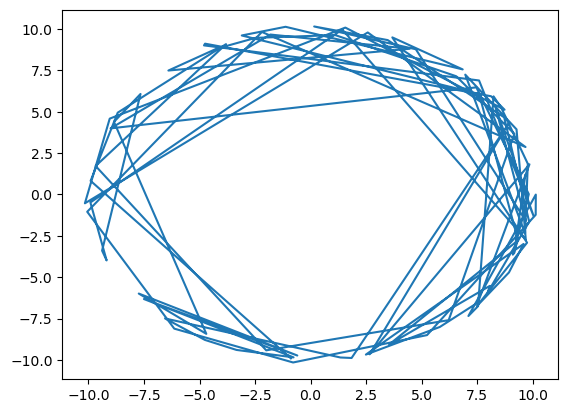

In [5]:
samples = samples[samples.shape[0]//2:]
plt.plot(samples[:,0], samples[:,1])
plt.show()

<br>

#### `PyTorch`

In [6]:
import torch
torch.set_default_dtype(torch.double)

In [7]:
def sphere(theta):
    return -20*(torch.sqrt(torch.sum(theta**2))-10)**2

In [8]:
def hmc(theta0, M, target, epsilon, L):
    thetas = torch.zeros([M, len(theta0)])
    theta = theta0.clone().detach().requires_grad_(True)
    
    logP = target(theta) 
    logP.backward()
    g = theta.grad
    accepts = 0
    
    for m in range(M): 
        p = torch.normal(torch.zeros(theta.shape)) 
        H = p.dot(p) / 2 - logP  
        thetanew = theta.clone().detach().requires_grad_(True)
        gnew = g.clone().detach()
        
        for l in range(L): 
            p.data += epsilon * gnew.data / 2   
            thetanew.data += epsilon * p.data   
            
            if thetanew.grad is not None:
                thetanew.grad.zero_()
                
            logPnew = target(thetanew)
            logPnew.backward()
            gnew = thetanew.grad            
            p.data += epsilon * gnew.data / 2   
            
        logPnew = target(thetanew)   
        Hnew = p.dot(p) / 2 - logPnew
        dH = H - Hnew    
        
        if torch.log(torch.rand(1)) < dH:
            g = gnew
            theta = thetanew
            logP = logPnew
            accepts += 1
            
        thetas[m,:] = theta.detach()
        
    print('Acceptance rate:', accepts/M)
    return thetas 

In [9]:
torch.manual_seed(42)
samples = hmc(torch.tensor([3.0, 0.0]), 200, lambda theta: sphere(theta), 0.2, 50)

Acceptance rate: 0.875


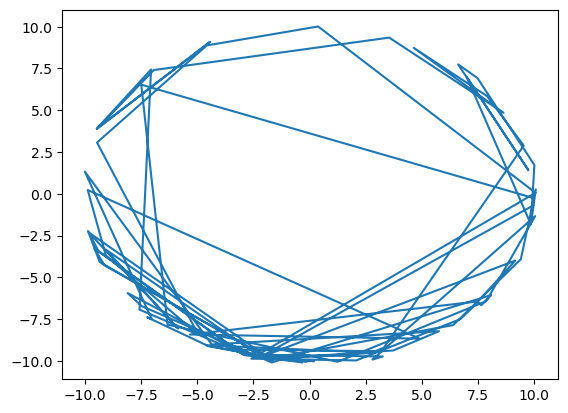

In [10]:
samples = samples[samples.shape[0]//2:]
plt.plot(samples.numpy()[:,0], samples.numpy()[:,1])
plt.show()